In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import scipy.stats as stats
import warnings
warnings.filterwarnings("ignore")

import sys
sys.path.append('../cmds/')

sns.set_theme()

In [47]:
FILEIN = '../data/dfa_analysis_data.xlsx'
sheet_exrets = 'factors'

retsx = pd.read_excel(FILEIN, sheet_name=sheet_exrets, usecols = ['Date', 'Mkt-RF', 'SMB', 'HML']).set_index('Date')

# proshares = pd.read_excel(FILEIN, sheet_name=sheet_proshares).set_index('date')
# fxrets = pd.read_excel(FILEIN, sheet_name=sheet_fxrets).set_index('date')
retsx

,Mkt-RF,SMB,HML
Date,,,
1926-07-31,0.0296,-0.0256,-0.0243
1926-08-31,0.0264,-0.0117,0.0382
1926-09-30,0.0036,-0.0140,0.0013
1926-10-31,-0.0324,-0.0009,0.0070
1926-11-30,0.0253,-0.0010,-0.0051
...,...,...,...
2024-04-30,-0.0467,-0.0239,-0.0052
2024-05-31,0.0434,0.0078,-0.0166
2024-06-30,0.0277,-0.0306,-0.0331


In [48]:
def performance_summary(return_data, annualization = 12):
    """ 
        Returns the Performance Stats for given set of returns
        Inputs: 
            return_data - DataFrame with Date index and Monthly Returns for different assets/strategies.
        Output:
            summary_stats - DataFrame with annualized mean return, vol, sharpe ratio. Skewness, Excess Kurtosis, Var (0.5) and
                            CVaR (0.5) and drawdown based on monthly returns. 
    """
    summary_stats = return_data.mean().to_frame('Mean').apply(lambda x: x*annualization)
    summary_stats['Volatility'] = return_data.std().apply(lambda x: x*np.sqrt(annualization))
    summary_stats['Sharpe Ratio'] = summary_stats['Mean']/summary_stats['Volatility']
    
    summary_stats['Skewness'] = return_data.skew()
    summary_stats['Excess Kurtosis'] = return_data.kurtosis()
    summary_stats['VaR (0.05)'] = return_data.quantile(.05, axis = 0)
    summary_stats['CVaR (0.05)'] = return_data[return_data <= return_data.quantile(.05, axis = 0)].mean()
    summary_stats['Min'] = return_data.min()
    summary_stats['Max'] = return_data.max()
    
    wealth_index = 1000*(1+return_data).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    summary_stats['Max Drawdown'] = drawdowns.min()
    summary_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    summary_stats['Bottom'] = drawdowns.idxmin()
    
    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    summary_stats['Recovery'] = recovery_date
    
    return summary_stats

In [49]:
performance_summary(retsx.loc[:'1980-12-31'], 12)

,Mean,Volatility,Sharpe Ratio,Skewness,Excess Kurtosis,VaR (0.05),CVaR (0.05),Min,Max,Max Drawdown,Peak,Bottom,Recovery
Mkt-RF,0.081138,0.205050,0.395696,0.432101,8.092179,-0.083985,-0.134000,-0.2913,0.3885,-0.846853,1929-08-31,1932-06-30,1945-02-28
SMB,0.033985,0.114568,0.296638,2.536654,24.237826,-0.043400,-0.058253,-0.0986,0.3656,-0.466505,1968-12-31,1974-12-31,1978-08-31
HML,0.049479,0.133825,0.369727,2.834453,22.626461,-0.042910,-0.067955,-0.1311,0.3561,-0.438920,1933-08-31,1935-03-31,1937-03-31


In [54]:

performance_stats = pd.DataFrame()

summary_1980 = performance_summary(retsx.loc[:'1980-12-31'], 12)[['Mean', 'Volatility', 'Sharpe Ratio', 'VaR (0.05)']]
summary_1981_2001 = performance_summary(retsx.loc['1981-01-01':'2001-12-31'], 12)[['Mean', 'Volatility', 'Sharpe Ratio', 'VaR (0.05)']]
summary_2002 = performance_summary(retsx.loc['2002-01-01':], 12)[['Mean', 'Volatility', 'Sharpe Ratio', 'VaR (0.05)']]
print('Summary Beginning to 1980')
print(summary_1980)
print('Summary 1981 to 2001')
print(summary_1981_2001)
print('Summary 2002 to End')
print(summary_2002)


Summary Beginning to 1980
            Mean  Volatility  Sharpe Ratio  VaR (0.05)
Mkt-RF  0.081138    0.205050      0.395696   -0.083985
SMB     0.033985    0.114568      0.296638   -0.043400
HML     0.049479    0.133825      0.369727   -0.042910
Summary 1981 to 2001
            Mean  Volatility  Sharpe Ratio  VaR (0.05)
Mkt-RF  0.077257    0.157396      0.490847   -0.064545
SMB    -0.000862    0.118346     -0.007283   -0.046515
HML     0.063776    0.111183      0.573612   -0.041790
Summary 2002 to End
            Mean  Volatility  Sharpe Ratio  VaR (0.05)
Mkt-RF  0.089488    0.154644      0.578674   -0.078735
SMB     0.011007    0.088944      0.123757   -0.039070
HML     0.000538    0.107348      0.005014   -0.041245


In [55]:
retsx.loc[:'1980-12-31'].corr()

,Mkt-RF,SMB,HML
Mkt-RF,1.000000,0.366298,0.437848
SMB,0.366298,1.000000,0.309133
HML,0.437848,0.309133,1.000000


In [56]:
retsx.loc['1981-01-01':'2001-12-31'].corr()

,Mkt-RF,SMB,HML
Mkt-RF,1.000000,0.164264,-0.527221
SMB,0.164264,1.000000,-0.453656
HML,-0.527221,-0.453656,1.000000


In [57]:
retsx.loc['2002-01-01':].corr()

,Mkt-RF,SMB,HML
Mkt-RF,1.000000,0.306309,0.127782
SMB,0.306309,1.000000,0.128111
HML,0.127782,0.128111,1.000000


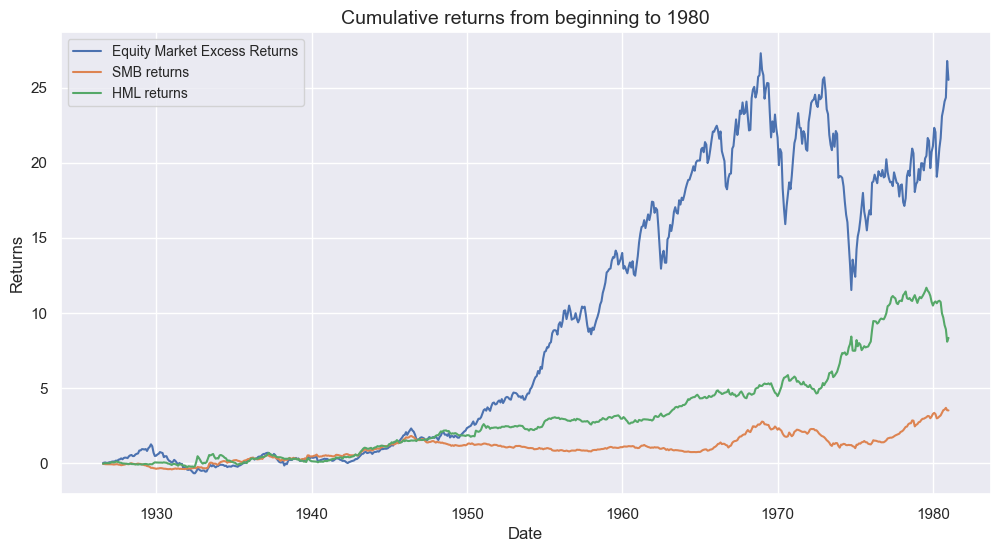

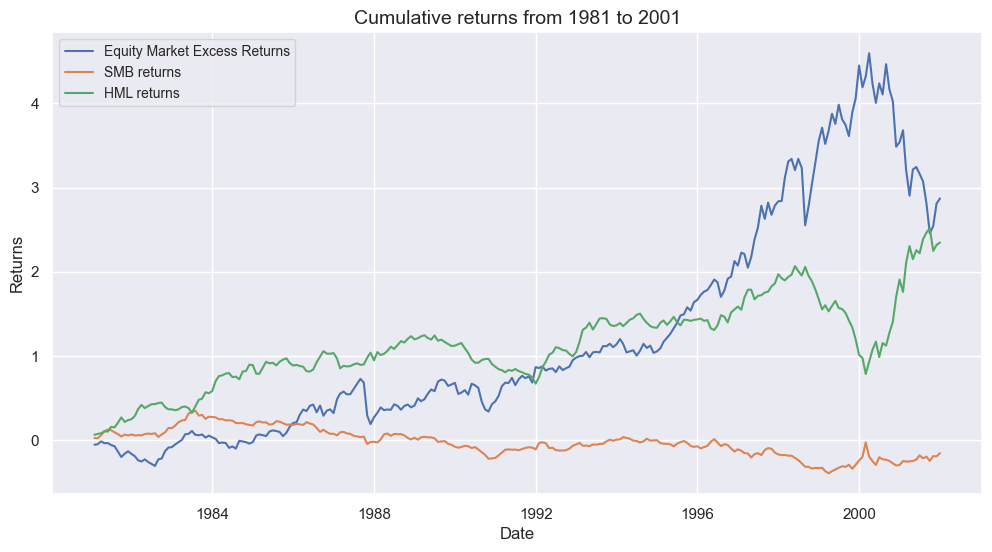

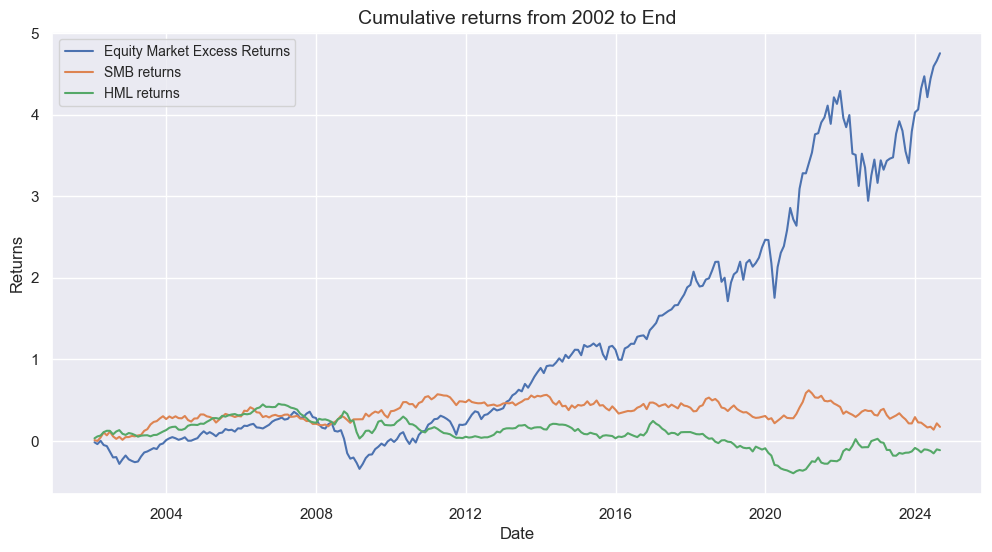

In [64]:
import matplotlib.pyplot as plt

# Plot the cumulative returns of the three factors. Create plots for the 1981-2001 subsample as
# well as the 2002-Present subsample.

def plot_rets(returns, title):
    cumulative_mkt = (1 + returns['Mkt-RF']).cumprod() - 1
    cumulative_smb = (1 + returns['SMB']).cumprod() - 1
    cumulative_hml = (1 + returns['HML']).cumprod() - 1
    
    # smb_mkt = smb_mkt.reindex(equity_mkt.index, method='ffill')
    # hml_mkt = hml_mkt.reindex(equity_mkt.index, method='ffill')
    
    plt.figure(figsize=(12, 6))
    plt.plot(cumulative_mkt, label='Equity Market Excess Returns', linewidth=1.5)
    plt.plot(cumulative_smb, label='SMB returns', linewidth=1.5)
    plt.plot(cumulative_hml, label='HML returns', linewidth=1.5)
    
    plt.title(title, fontsize=14)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Returns', fontsize=12)
    plt.legend(loc='best', fontsize=10)
    plt.grid(True)
    
    plt.show()

plot_rets(retsx.loc[:'1980-12-31'], 'Cumulative returns from beginning to 1980')
plot_rets(retsx.loc['1981-01-01':'2001-12-31'], 'Cumulative returns from 1981 to 2001')
plot_rets(retsx.loc['2002-01-01':], 'Cumulative returns from 2002 to End')

Does it appear that all three factors were valuable in 1981-2001? And post-2001? Would you
advise DFA to continue emphasizing all three factors?

- yes, no, lessening importance of market factors

# CAPM

In [70]:
sheet_portfolio = 'portfolios (total returns)'
tot_rets = pd.read_excel(FILEIN, sheet_name=sheet_portfolio).set_index('Date')
tot_rets

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.058248,-0.017006,0.004875,-0.014580,0.020534,0.012077,0.024192,0.004926,-0.026049,-0.003344,...,0.015893,0.015278,0.012978,0.002727,0.024678,0.034539,0.060902,0.020266,0.031111,0.005623
1926-08-31,-0.020206,-0.080282,0.013796,0.014606,0.083968,0.023618,-0.011849,0.040084,0.005038,0.061675,...,0.013336,0.038730,0.020021,0.021706,0.053422,0.010124,0.041903,0.020131,0.054849,0.077576
1926-09-30,-0.048291,-0.026154,-0.043417,-0.032729,0.008649,-0.026540,-0.012618,0.010829,-0.035480,-0.009401,...,0.010923,-0.005250,-0.017636,0.014646,0.008730,-0.012906,0.036538,0.000950,-0.007487,-0.024284
1926-10-31,-0.093729,-0.035519,-0.034948,0.034413,-0.025476,-0.028069,-0.032663,-0.050745,-0.080191,-0.013213,...,-0.033361,-0.026559,-0.021070,-0.031051,-0.053525,-0.027413,-0.030071,-0.022437,-0.046719,-0.058129
1926-11-30,0.055888,0.041877,0.024623,-0.044494,0.005362,0.031033,-0.023690,0.030078,0.051546,0.027292,...,0.034448,0.023887,0.037335,0.049320,0.018213,0.042946,0.025326,0.015204,0.036619,0.025636
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,-0.125428,-0.071861,-0.075104,-0.074424,-0.075468,-0.068284,-0.082740,-0.063410,-0.056108,-0.068670,...,-0.057189,-0.064262,-0.060023,-0.068561,-0.057337,-0.039996,0.011908,-0.044722,-0.049938,-0.054745
2024-05-31,0.072329,0.032521,0.049308,0.035566,0.047891,0.045975,0.032268,0.055056,0.048427,0.050718,...,0.025654,0.021790,0.023887,0.052926,0.036067,0.059812,0.041988,0.030522,0.040484,0.042659
2024-06-30,-0.042989,-0.023202,-0.055955,-0.016409,-0.025588,-0.019200,-0.020791,-0.020615,-0.015364,-0.028811,...,-0.006071,-0.017618,-0.022853,-0.016611,-0.027547,0.061172,0.011073,0.003226,-0.016692,0.006103


In [74]:
rf = pd.read_excel(FILEIN, sheet_name=sheet_exrets, usecols = ['Date','RF']).set_index('Date')
port_xs_rets = tot_rets.sub(rf['RF'], axis=0)
port_xs_rets

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
Date,,,,,,,,,,,,,,,,,,,,,
1926-07-31,0.056048,-0.019206,0.002675,-0.016780,0.018334,0.009877,0.021992,0.002726,-0.028249,-0.005544,...,0.013693,0.013078,0.010778,0.000527,0.022478,0.032339,0.058702,0.018066,0.028911,0.003423
1926-08-31,-0.022706,-0.082782,0.011296,0.012106,0.081468,0.021118,-0.014349,0.037584,0.002538,0.059175,...,0.010836,0.036230,0.017521,0.019206,0.050922,0.007624,0.039403,0.017631,0.052349,0.075076
1926-09-30,-0.050591,-0.028454,-0.045717,-0.035029,0.006349,-0.028840,-0.014918,0.008529,-0.037780,-0.011701,...,0.008623,-0.007550,-0.019936,0.012346,0.006430,-0.015206,0.034238,-0.001350,-0.009787,-0.026584
1926-10-31,-0.096929,-0.038719,-0.038148,0.031213,-0.028676,-0.031269,-0.035863,-0.053945,-0.083391,-0.016413,...,-0.036561,-0.029759,-0.024270,-0.034251,-0.056725,-0.030613,-0.033271,-0.025637,-0.049919,-0.061329
1926-11-30,0.052788,0.038777,0.021523,-0.047594,0.002262,0.027933,-0.026790,0.026978,0.048446,0.024192,...,0.031348,0.020787,0.034235,0.046220,0.015113,0.039846,0.022226,0.012104,0.033519,0.022536
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-04-30,-0.130128,-0.076561,-0.079804,-0.079124,-0.080168,-0.072984,-0.087440,-0.068110,-0.060808,-0.073370,...,-0.061889,-0.068962,-0.064723,-0.073261,-0.062037,-0.044696,0.007208,-0.049422,-0.054638,-0.059445
2024-05-31,0.067929,0.028121,0.044908,0.031166,0.043491,0.041575,0.027868,0.050656,0.044027,0.046318,...,0.021254,0.017390,0.019487,0.048526,0.031667,0.055412,0.037588,0.026122,0.036084,0.038259
2024-06-30,-0.047089,-0.027302,-0.060055,-0.020509,-0.029688,-0.023300,-0.024891,-0.024715,-0.019464,-0.032911,...,-0.010171,-0.021718,-0.026953,-0.020711,-0.031647,0.057072,0.006973,-0.000874,-0.020792,0.002003


In [116]:

summary_1981_present = performance_summary(port_xs_rets.loc['1981-01-01':], 12)[['Mean', 'Volatility', 'Sharpe Ratio', 'VaR (0.05)']]

print('Summary 1981 to present')
summary_1981_present


Summary 1981 to present


,Mean,Volatility,Sharpe Ratio,VaR (0.05)
SMALL LoBM,0.006671,0.273771,0.024366,-0.126059
ME1 BM2,0.088689,0.236403,0.375163,-0.094747
ME1 BM3,0.092006,0.201252,0.457170,-0.086227
ME1 BM4,0.115998,0.194270,0.597099,-0.076972
SMALL HiBM,0.127838,0.210037,0.608646,-0.088535
ME2 BM1,0.058868,0.245156,0.240125,-0.104096
ME2 BM2,0.100515,0.205528,0.489059,-0.085661
ME2 BM3,0.105946,0.185777,0.570288,-0.078490
ME2 BM4,0.108835,0.182098,0.597670,-0.076138
ME2 BM5,0.115994,0.215616,0.537967,-0.096398


Can the difference in mean excess returns of the portfolios be explained by differences in
their volatilities? Or by their VaR(.05) statistics?

In [122]:
mkt_ret = sm.add_constant(retsx[['Mkt-RF']])
capm_greeks = pd.DataFrame(columns=['alpha', 'beta', 'treynor', 'ir', 'rsquared'])
for col in port_xs_rets:

    port_rets = port_xs_rets[col]
    model = sm.OLS(port_rets, mkt_ret).fit()
    # print(model.params.T)
    alpha = model.params[0]
    beta = model.params[1]
    resid = model.resid.std()
    treynor = 12 * port_rets.mean()/beta
    ir = np.sqrt(12) * alpha / resid
    rsquared = model.rsquared
    capm_greeks.loc[col] = [alpha, beta, treynor, ir, rsquared]

capm = capm_greeks.T
capm

,SMALL LoBM,ME1 BM2,ME1 BM3,ME1 BM4,SMALL HiBM,ME2 BM1,ME2 BM2,ME2 BM3,ME2 BM4,ME2 BM5,...,ME4 BM1,ME4 BM2,ME4 BM3,ME4 BM4,ME4 BM5,BIG LoBM,ME5 BM2,ME5 BM3,ME5 BM4,BIG HiBM
alpha,-0.005404,-0.002804,0.000507,0.002792,0.004104,-0.002346,0.000958,0.001452,0.002103,0.003021,...,-0.000077,0.000472,0.000955,0.001584,0.000845,0.000270,0.000005,0.000579,-0.000865,0.000548
beta,1.606425,1.392075,1.392537,1.258251,1.359165,1.268737,1.225856,1.196331,1.204818,1.373805,...,1.087725,1.089456,1.098300,1.163564,1.390156,0.960912,0.941852,0.964907,1.097018,1.299343
treynor,0.041867,0.058065,0.086609,0.108863,0.118473,0.060044,0.091618,0.096799,0.103183,0.108627,...,0.081385,0.087439,0.092675,0.098567,0.089527,0.085602,0.082294,0.089435,0.072777,0.087293
ir,-0.223670,-0.156078,0.032591,0.201020,0.249252,-0.193377,0.091825,0.149746,0.201901,0.225760,...,-0.012075,0.087039,0.144039,0.189456,0.068043,0.060398,0.001046,0.092973,-0.101225,0.038576
rsquared,0.511572,0.587220,0.654571,0.660384,0.617467,0.721505,0.765699,0.782939,0.760171,0.714006,...,0.872931,0.905173,0.866582,0.821155,0.748187,0.916535,0.916380,0.850531,0.796248,0.665028


In [123]:
mae = abs(capm.loc['alpha']).sum()
mae

0.039765620862441564

capm holds! low mae

If (CAPM) were true, what would be true of the Treynor Ratios, alphas, and Information
Ratios?

low treynor, low alphas and very low ir?

In [134]:
import pandas as pd
import statsmodels.api as sm

# Assuming port_xs_rets is already defined and contains excess returns
mean_exrets = pd.DataFrame(columns=['mean_exrets'], index=port_xs_rets.columns)

# Calculate mean excess returns for each portfolio
for col in port_xs_rets.columns:
    mean_exrets.loc[col] = port_xs_rets[col].mean()

# Extract betas from capm and ensure they are aligned
betas = capm.loc['beta']

# Check the data types
print("Data types:")
print(mean_exrets.dtypes)
print(betas.dtypes)

# Convert to numeric if necessary
mean_exrets['mean_exrets'] = pd.to_numeric(mean_exrets['mean_exrets'], errors='coerce')
betas = pd.to_numeric(betas, errors='coerce')

# # Check for NaNs after conversion
# print("Mean excess returns after conversion:")
# print(mean_exrets)
# print("Betas after conversion:")
# print(betas)

# Check for index alignment
if not mean_exrets.index.equals(betas.index):
    raise ValueError("Index of mean_exrets and betas do not match!")

# Prepare the data for regression
data = pd.DataFrame({
    'mean_excess_returns': mean_exrets['mean_exrets'],  # Extracting Series
    'betas': betas
})

# Add a constant for the intercept
data = sm.add_constant(data)

# Run the OLS regression
model = sm.OLS(data['mean_excess_returns'], data[['const', 'betas']]).fit()

# Extract R-squared, intercept (η), and regression coefficient (λm)
r_squared = model.rsquared
intercept = model.params['const']
regression_coefficient = model.params['betas']

# Output the results
print(f'R-squared: {r_squared}')
print(f'Intercept (η): {intercept}')
print(f'Regression Coefficient (λm): {regression_coefficient}')


Data types:
mean_exrets    object
dtype: object
float64
R-squared: 0.09160580379648675
Intercept (η): 0.0041945868362375655
Regression Coefficient (λm): 0.00386245007029196
